Objective: to get overall stats of the 12 i94 monthly SAS7BDAT files. e.g. how many rows per month, for 2016?

In [1]:
import os
import pyspark
import configparser
from pyspark.sql import SparkSession

In [4]:
# Dev config from the non-secret configuration file
config_dev = configparser.ConfigParser()
config_dev.read_file(open('aws_dev.cfg'))

PAR_I94_FILE_BY_NONE = config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94_FILE_BY_NONE')
PAR_I94_FILE_BY_I94MON = config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94_FILE_BY_I94MON')
PAR_I94_FILE_BY_I94YR_I94MON = config_dev.get('DATA_PATHS_LOCAL', 'PAR_I94_FILE_BY_I94YR_I94MON')

In [5]:
spark = SparkSession.builder.\
    enableHiveSupport().getOrCreate()

In [7]:
df_i94_by_none = spark.read.parquet(PAR_I94_FILE_BY_NONE)

In [8]:
df_i94_by_none.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [9]:
df_i94_by_none.createOrReplaceTempView("df_i94_by_none")
df_i94_by_none_agg_1 = spark.sql("""
select
    i94yr,
    i94mon,
    count(*) as records
from df_i94_by_none
group by 1, 2
""")
df_i94_by_none_agg_1.show()

+------+------+-------+
| i94yr|i94mon|records|
+------+------+-------+
|2016.0|  10.0|3649136|
|2016.0|  12.0|3432990|
|2016.0|   3.0|3157072|
|2016.0|   9.0|3733786|
|2016.0|   2.0|2570543|
|2016.0|   4.0|3096313|
|2016.0|   6.0|3574989|
|2016.0|   8.0|4103570|
|2016.0|  11.0|2914926|
|2016.0|   1.0|2847924|
|2016.0|   5.0|3444249|
|2016.0|   7.0|4265031|
+------+------+-------+



In [11]:
df_i94_by_none_agg_1 = df_i94_by_none_agg_1.orderBy('i94yr', 'i94mon')
df_i94_by_none_agg_1.show()

+------+------+-------+
| i94yr|i94mon|records|
+------+------+-------+
|2016.0|   1.0|2847924|
|2016.0|   2.0|2570543|
|2016.0|   3.0|3157072|
|2016.0|   4.0|3096313|
|2016.0|   5.0|3444249|
|2016.0|   6.0|3574989|
|2016.0|   7.0|4265031|
|2016.0|   8.0|4103570|
|2016.0|   9.0|3733786|
|2016.0|  10.0|3649136|
|2016.0|  11.0|2914926|
|2016.0|  12.0|3432990|
+------+------+-------+



In [13]:
total_rows = df_i94_by_none.count()
print(f"total_rows = {total_rows}")

total_rows = 40790529


In [20]:
df_i94_by_none_agg_1.createOrReplaceTempView("df_i94_by_none_agg_1")
df_i94_by_none_agg_2 = spark.sql(f"""
select
    i94yr,
    i94mon,
    records,
    records / {total_rows} * 100 as percent_records
from df_i94_by_none_agg_1
""")
df_i94_by_none_agg_2.show()

+------+------+-------+------------------+
| i94yr|i94mon|records|   percent_records|
+------+------+-------+------------------+
|2016.0|   1.0|2847924| 6.981826590187149|
|2016.0|   2.0|2570543| 6.301813344955639|
|2016.0|   3.0|3157072|7.7397182076260895|
|2016.0|   4.0|3096313| 7.590764513007418|
|2016.0|   5.0|3444249| 8.443746831525525|
|2016.0|   6.0|3574989| 8.764262410031504|
|2016.0|   7.0|4265031|10.455934513622022|
|2016.0|   8.0|4103570|10.060104883660616|
|2016.0|   9.0|3733786| 9.153561112188568|
|2016.0|  10.0|3649136|  8.94603744903627|
|2016.0|  11.0|2914926| 7.146085308185143|
|2016.0|  12.0|3432990| 8.416144835974057|
+------+------+-------+------------------+



In [28]:
df_i94_by_none_agg_2_pd = df_i94_by_none_agg_2.toPandas()

In [31]:
%matplotlib inline

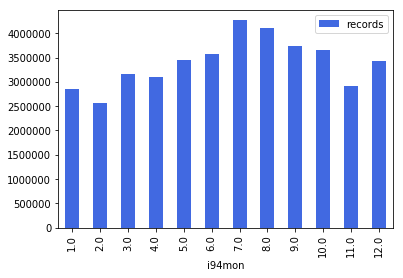

In [34]:
df_i94_by_none_agg_2_pd.plot.bar(x='i94mon', y='records', color='royalblue')

Casual observations:

* 40,790,529 datapoints during 2016 in i94 file.
* there appears to be more data points during the summer season (July-Aug)
* lowest number of data points during Feburary, followed by November.


In [35]:
spark.stop()